In [1]:
import jax
import jax.numpy as np
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy,pickle

from jax import jit
import pandas as pd
import blackjax

In [2]:
import sys,os,importlib,pdb
sys.path.append('/mnt/home/szheng/projects/util_code')
import gm

import scipy
from scipy.signal import find_peaks
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
from importlib import reload

import copy

%matplotlib inline

In [3]:
sess_name="e15_13f1_220117"
py_data_dir = "/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data"
fr_ = pickle.load(open(os.path.join(py_data_dir,'fr.p'),'rb'))
pos_bins = fr_['pos_bins']['lin']
bin_to_lin=np.concatenate([pos_bins[:-1,None],pos_bins[1:,None]],axis=1).mean(axis=1)

fr = fr_['df']['pyr']
# truncate the timepoints to only keep the non intertrial part
lin_endpoints = [15,205]
fr = fr.query(f'{lin_endpoints[1]}>=lin>={lin_endpoints[0]}')

fr_map_ = pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map_trial']

2022-06-24 10:10:59.087168: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [4]:
unit_int = 31
unit_str = f'unit_{unit_int}'

unit_ind_in_pyr = 0

In [7]:
reload(gm)

<module 'gm' from '/mnt/home/szheng/projects/util_code/gm.py'>

In [8]:
trial_ind_dict = dict(fr.groupby('visitedArm')['trial'].unique())
fr_map_one_unit_both_trials_dict = {k:val[unit_ind_in_pyr] for k,val in fr_map_.items()}
pars=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None)

In [9]:
pars_rand=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None,random_init=True)

In [10]:

import gm_glm_bayesian as glm
reload(glm)

<module 'gm_glm_bayesian' from '/mnt/home/szheng/projects/util_code/gm_glm_bayesian.py'>

In [11]:
regressors=glm.get_regressors(fr)
fs_l_final = glm.forward(regressors,pars)

In [12]:
def collapse_pars(pars):
    tot = []
    for k,val in pars.items():
        val_melted = pd.DataFrame(val).reset_index().melt(id_vars='index') # df with cols: variable (col index, corresponding to the fields); value; index just for easy unmelting/pivoting 
        val_melted['key'] = k
        tot.append(val_melted)
    tot = pd.concat(tot,axis=0)
    return tot
    

def recombine_pars(tot_values,tot):
    '''
    given 
    tot: df, all parameters, columns: key (eg mu), variable (i.e. column), index: old index in the df for easy pivoting
    tot_values: the corresponding values
    '''
    tot_copy = copy.copy(tot)
    tot_copy['values'] = tot_values
    tot_copy['variable']= tot_copy['variable'].astype(int)
    par = {}
    for k,val in tot_copy.groupby('key'):
        
        val_unmelted=val[['value','variable','index']].pivot(values='value',columns='variable',index='index') # inverse of val_melted, recover val: ntrials x nfields for each key
        par[k] = numpy.squeeze(val_unmelted.values)
    return par

In [38]:
@jit
def logpdf_poisson_reduce(fs_l_final,target,mask):
    logpdf_element = stats.poisson.logpmf(target,fs_l_final)
#     logpdf = np.sum(logpdf_element * mask) / np.sum(mask)
    logpdf = np.sum(logpdf_element * mask) #/ np.sum(mask)
    return logpdf

def logpdf_no_reg(regressors,pars,target,mask=None,noise_type="poisson"):
    if mask is None:
        mask = np.ones_like(target)
    fs_l_final = glm.forward(regressors,pars)
    if noise_type=="poisson":
        logpdf = logpdf_poisson_reduce(fs_l_final,target,mask)
    return logpdf 

def negative_logpdf_no_reg(regressors,pars,target,mask=None,noise_type="poisson"):
    logpdf=logpdf_no_reg(regressors,pars,target,mask=mask,noise_type=noise_type)
    return -logpdf

def logpdf_using_collapsedparam(logpdf,regressors,pars_collapsed_value,target,**kwargs):
    pars_recombined = recombine_pars(pars_collapsed_value,pars_collapsed)
    return logpdf(regressors,pars_recombined,target,**kwargs)
    
    

def fit(regressors,pars,target,mask=None,sampler_func=blackjax.mala,sampler_kw={'step_size':1e-5},num_samples=1000,rng_key_int=0):
    rng_key = jax.random.PRNGKey(rng_key_int)
#     regressors=glm.get_regressors(fr)

#     logprob = lambda x:logpdf_no_reg(regressors,x,target,mask)
    logprob = lambda x:negative_logpdf_no_reg(regressors,x,target,mask)
#     logprob = lambda x:logpdf_using_collapsedparam(logpdf_no_reg,regressors,x,target,mask=mask)
    
    sampler = sampler_func(logprob,**sampler_kw)
#     pars=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None)
    initial_state=sampler.init(pars)
    kernel = jax.jit(sampler.step)
    
    @jax.jit
    def one_step(state,rng_key):
        state, _ =kernel(rng_key,state)
        return state, state
    
    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)
    
#     pars_samples = states.position
#     logprob_samples = states.logprob
    
    
#     return pars_samples,logprob_samples,states
    return states

 

    


In [95]:
from jax.example_libraries import optimizers as jax_opt
from jax import value_and_grad, grad, jit, vmap, jacfwd, jacrev

def train_adam(func,regressors,pars,ys_l,noise_type='poisson',lr=0.1,niters=100,mask=None):
# def train_adam(func,*args,argnums=1,lr=0.1,niters=100,**kwargs):
    opt_init,opt_update,get_params=jax_opt.adam(lr)
    loss_l=[]
    @jit
    def train_step(step_i,opt_state):
        params=get_params(opt_state)
        loss,grads = value_and_grad(func,argnums=1)(regressors,params,ys_l,noise_type=noise_type,mask=mask) # notice the params here
        # loss,grads = value_and_grad(func,argnums=argnums)(*args,**kwargs) 
        return loss, opt_update(step_i, grads, opt_state)
    # opt_state=opt_init(args[argnums])
    opt_state=opt_init(pars)
    for ii in range(niters):
        loss,opt_state = train_step(ii,opt_state)
        loss_l.append(loss)
    return get_params(opt_state), np.array(loss_l)


In [93]:
logpdf_no_reg(regressors,pars,target,mask=None,noise_type="poisson")

DeviceArray(-0.35757148, dtype=float32)

In [108]:
pars_learned,loss_l=train_adam(negative_logpdf_no_reg,regressors,pars,target,lr=1,niters=100)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs


In [109]:
loss_l

DeviceArray([0.35757154, 0.34872964, 0.34303224, 0.3405851 , 0.33910722,
             0.33769363, 0.33679777, 0.33627325, 0.33575836, 0.33498567,
             0.33391812, 0.33339503, 0.33255753, 0.3320576 , 0.331646  ,
             0.33166787, 0.3310149 , 0.33086905, 0.3363279 , 0.33096918,
             0.32981113, 0.328583  , 0.3284997 , 0.32853508, 0.32842085,
             0.3458052 , 0.32799265, 0.32779288, 0.32752   , 0.3272436 ,
             0.32706365, 0.32695392, 0.32665056, 0.3264966 , 0.32639676,
             0.3263175 , 0.32618025, 0.32635754, 0.3260898 , 0.3262877 ,
             0.32608676, 0.32602867, 0.32599705, 0.32595602, 0.3258607 ,
             0.32573426, 0.325626  , 0.32551438, 0.32542536, 0.32535243,
             0.32527918, 0.3252077 , 0.3251579 , 0.32508564, 0.3249815 ,
             0.32492995, 0.32492608, 0.32488683, 0.32484168, 0.3247686 ,
             0.3247817 , 0.3245962 , 0.32449442, 0.32436016, 0.3244396 ,
             0.32440042, 0.32430616, 0.32421696, 0.

In [68]:
#hmc
sampler_func = blackjax.hmc
pars_collapsed_value = pars_collapsed['value'].values
inv_mass_matrix = np.eye(len(pars_collapsed_value)) * 0.5
sampler_kw = {'step_size':1e-4,'inverse_mass_matrix':inv_mass_matrix,'num_integration_steps':50}

# pars_collapsed = collapse_pars(pars)

states=fit(regressors,pars,target,sampler_func=sampler_func,sampler_kw=sampler_kw,mask=None,num_samples=1000,rng_key_int=0)
# pars_samples=fit(regressors,pars_collapsed_value,target,sampler_func=sampler_func,sampler_kw=sampler_kw,mask=None,num_samples=10,rng_key_int=0)


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.06 µs


In [111]:
#mala
%%time
sampler_func = blackjax.mala
sampler_kw = {'step_size':1e-3}

# pars_collapsed = collapse_pars(pars)

states=fit(regressors,pars,target,sampler_func=sampler_func,sampler_kw=sampler_kw,mask=None,num_samples=1000,rng_key_int=0)
# pars_samples=fit(regressors,pars_collapsed_value,target,sampler_func=sampler_func,sampler_kw=sampler_kw,mask=None,num_samples=10,rng_key_int=0)


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


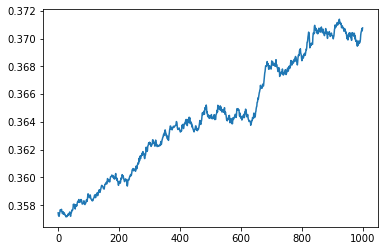

In [112]:
plt.plot(states.logprob)

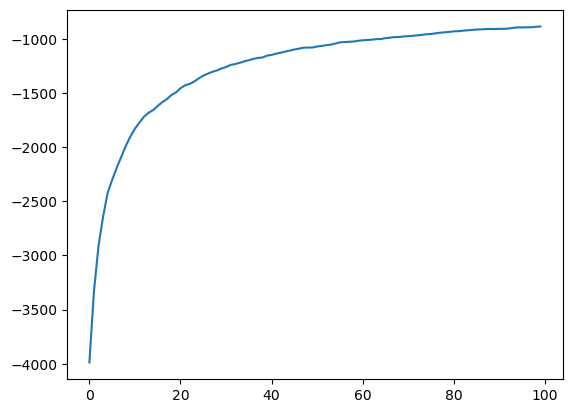

In [111]:
# observed=numpy.random.normal(loc=10,scale=20,size=(100,))
# def logpdf(loc,scale,observed=observed):
#     return np.sum(stats.norm.logpdf(observed,loc,scale))

# def fit_test(logpdf,num_samples=100,step_size=1e-4):
    
#     rng_key = jax.random.PRNGKey(0)

#     logprob = lambda x:logpdf(**x)
#     sampler = blackjax.mala(logprob,step_size)

#     initial_state=sampler.init({'loc':1.,'scale':2.})
#     kernel = jax.jit(sampler.step)
    
#     @jax.jit
#     def one_step(state,rng_key):
#         state, _ =kernel(rng_key,state)
#         return state, state
    
#     keys = jax.random.split(rng_key, num_samples)
#     _, states = jax.lax.scan(one_step, initial_state, keys)
    
#     return states

# states=fit_test(logpdf)
# plt.plot(states.logprob)
    

In [79]:
@jit
def logpdf_poisson_reduce(fs_l_final,target,mask):
    logpdf_element = stats.poisson.logpmf(target,fs_l_final)
    logpdf = np.sum(logpdf_element * mask) / np.sum(mask)
#     logpdf = np.sum(logpdf_element * mask) #/ np.sum(mask)
    return logpdf

def logpdf_no_reg(regressors,pars,target,mask=None,noise_type="poisson"):
    if mask is None:
        mask = np.ones_like(target)
    fs_l_final = glm.forward(regressors,pars)
    if noise_type=="poisson":
        logpdf = logpdf_poisson_reduce(fs_l_final,target,mask)
    return logpdf

In [75]:
target.shape

(47400,)

In [80]:
mask=None
target = fr[unit_str].values
step_size=1
num_samples=1
rng_key_int=0
rng_key = jax.random.PRNGKey(rng_key_int)
pars_ = pars_rand
#     regressors=glm.get_regressors(fr)
logprob = lambda x:logpdf_no_reg(regressors,x,target,mask)
import mala
sampler = blackjax.mala(logprob,step_size)
# sampler = mala.MALAInfo(logprob,step_size)
#     pars=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None)
initial_state=sampler.init(pars_)
kernel = jax.jit(sampler.step)

@jax.jit
def one_step(state,rng_key):
    state, _ =kernel(rng_key,state)
    return state, state

keys = jax.random.split(rng_key, num_samples)
_, states = jax.lax.scan(one_step, initial_state, keys)

pars_samples = states.position

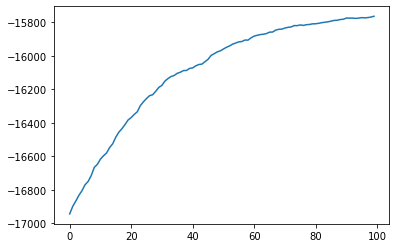

In [62]:
plt.plot(states.logprob)

In [81]:
next_state=kernel(rng_key,initial_state)
next_state[1]

MALAInfo(acceptance_probability=DeviceArray(0.99958044, dtype=float32), is_accepted=DeviceArray(True, dtype=bool))

In [32]:
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp
def transition_probability(state, new_state, step_size):
    """Transition probability to go from `state` to `new_state`"""
    theta = jax.tree_util.tree_map(
        lambda new_x, x, g: new_x - x - step_size * g,
        new_state.position,
        state.position,
        state.logprob_grad,
    )
    theta_ravel, _ = ravel_pytree(theta)
    return -0.25 * (1.0 / step_size) * jnp.dot(theta_ravel, theta_ravel)

In [82]:
transition_probability(initial_state,next_state[0],step_size)

DeviceArray(-100.80417, dtype=float32)

In [83]:
transition_probability(next_state[0],initial_state,step_size)

DeviceArray(-100.79297, dtype=float32)

In [74]:
initial_state.logprob_grad['logb']

DeviceArray([ 6.5430395e-05,  1.5828848e-03,  1.4437962e-04,
              3.4623456e-04,  7.5700955e-04,  6.8748428e-04,
              2.5478186e-04,  6.9838011e-04, -2.4681739e-04,
             -1.1062223e-04, -1.4296584e-04, -9.7398704e-05,
              1.6970784e-04,  1.2086508e-03,  2.0381454e-03,
              1.5123321e-04,  5.1612384e-04,  4.9322989e-05,
             -2.6727159e-05,  4.9421116e-04, -3.0659742e-04,
             -5.2715890e-04,  1.1292747e-03, -1.0139202e-04,
              1.8808891e-05, -2.9908988e-04, -4.8550678e-04,
             -1.6636748e-04,  1.2288517e-03, -3.4255933e-04,
              1.2704358e-04,  6.0518761e-04,  9.2895643e-04,
             -8.1355689e-04,  3.9735896e-04], dtype=float32)

In [70]:
initial_state.logprob_grad

{'logb': DeviceArray([  3.101425  ,  75.028595  ,   6.8435917 ,  16.41144   ,
               35.88226   ,  32.586384  ,  12.076456  ,  33.102272  ,
              -11.699281  ,  -5.2433133 ,  -6.77665   ,  -4.615894  ,
                8.044266  ,  57.290546  ,  96.607925  ,   7.1684413 ,
               24.464016  ,   2.3379586 ,  -1.2667016 ,  23.425634  ,
              -14.532782  , -24.987766  ,  53.528183  ,  -4.8057704 ,
                0.89160436, -14.1769085 , -23.013     ,  -7.8858976 ,
               58.24741   , -16.237335  ,   6.021811  ,  28.685871  ,
               44.03173   , -38.56414   ,  18.834633  ], dtype=float32),
 'logsigmas': DeviceArray([[ 0.00000000e+00, -8.92909616e-03],
              [ 2.66119647e+00,  2.28577805e+00],
              [ 8.64122510e-02,  1.14519089e-01],
              [-8.30365196e-02,  1.43211812e-01],
              [-8.00702721e-02, -2.98437208e-01],
              [ 1.15834042e-01,  3.92913312e-01],
              [ 3.48091014e-02,  2.61439886e-0

In [51]:
new_state=next_state[0]
state=initial_state
delta=(new_state.logprob
- state.logprob
+ transition_probability(new_state, state, step_size)
- transition_probability(state, new_state, step_size))

In [52]:
delta

DeviceArray(0.21672058, dtype=float32)

In [53]:
new_state.logprob-state.logprob

DeviceArray(31.169922, dtype=float32)

In [204]:
jnp.exp(delta)

DeviceArray(1.0000229, dtype=float32)

In [180]:
gg = grad(logprob)(pars_)
new_pars_=jax.tree_map(lambda param,g:param+g*step_size,pars_,gg)

In [181]:
logprob(new_pars_)

DeviceArray(-0.36444896, dtype=float32)

In [182]:
initial_state.logprob

DeviceArray(-0.36465356, dtype=float32)

In [183]:
next_state[0].logprob

DeviceArray(-0.4316002, dtype=float32)

In [117]:
states.logprob

DeviceArray([-0.36465344, -0.36466208, -0.36468038, -0.36468774,
             -0.36468405, -0.36468664, -0.3647085 , -0.36468825,
             -0.36471877, -0.36471063, -0.3647189 , -0.3647096 ,
             -0.36473554, -0.36473346, -0.36473498, -0.3647153 ,
             -0.36469135, -0.36469382, -0.3647053 , -0.3647322 ,
             -0.36471483, -0.36473024, -0.36475137, -0.3647337 ,
             -0.36470062, -0.36471853, -0.36470821, -0.36471906,
             -0.36473703, -0.3647197 , -0.3647507 , -0.36476406,
             -0.36480147, -0.36479118, -0.36476323, -0.3647538 ,
             -0.36474982, -0.3647409 , -0.36474466, -0.36475366,
             -0.36475685, -0.36477056, -0.3648079 , -0.36480576,
             -0.36481264, -0.36483452, -0.36480072, -0.36480206,
             -0.36480585, -0.36477795, -0.36478236, -0.3648093 ,
             -0.36482704, -0.36484283, -0.36484072, -0.36483678,
             -0.36486387, -0.36487952, -0.3648613 , -0.3648762 ,
             -0.36487597,

In [17]:
numpy.random.rand(3,2)

array([[0.8406445 , 0.25332715],
       [0.81518246, 0.24882167],
       [0.16330583, 0.31820639]])

In [101]:

pars_samples=fit(regressors,pars,target,mask=None,num_samples=100,rng_key_int=0)

In [11]:
%%time
target = fr[unit_str].values
pars_samples,logprob_samples,states=fit(regressors,pars,target,mask=None,step_size=1e-2,num_samples=10000,rng_key_int=0)

CPU times: user 1min 19s, sys: 0 ns, total: 1min 19s
Wall time: 1min 19s


In [90]:
target = fr[unit_str].values
pars_samples_rand,logprob_samples_rand,states_rand=fit(regressors,pars_rand,target,mask=None,step_size=1e-4,num_samples=10000,rng_key_int=0)


In [92]:
pars_initial = {k:val[0] for k,val in pars_samples_rand.items()}
pars_end = {k:val[-1] for k,val in pars_samples_rand.items()}

In [93]:
logpdf_no_reg(regressors,pars_initial,target,mask=None,noise_type="poisson")

DeviceArray(-0.35340953, dtype=float32)

In [94]:
logpdf_no_reg(regressors,pars_end,target,mask=None,noise_type="poisson")

DeviceArray(-0.3606335, dtype=float32)

In [64]:
fr_map_[0].shape

(333, 100, 21)

In [81]:
import gm_plot as gp
reload(gm)

<module 'gm' from '/mnt/home/szheng/projects/util_code/gm.py'>

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>, 14.52716227163636)

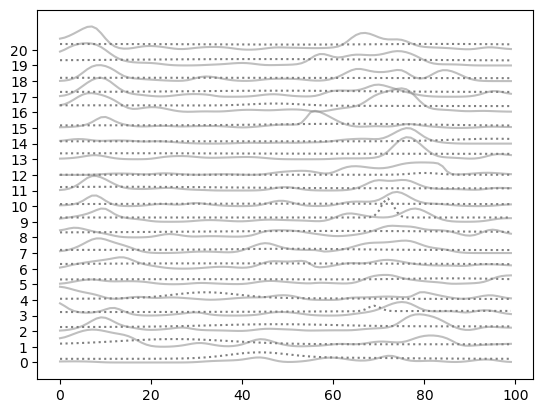

In [98]:
pars_ = pars_end#pars#
tr=0
ys_l = fr_map_[tr][unit_ind_in_pyr]
pars_ = {k:val[trial_ind_dict[tr].astype(int)] for k,val in pars_.items()}
gp.plot_fit_original(ys_l,pars_,bin_to_lin=None,fig=None,ax=None,nooriginal=False,displacement=None)

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>, 14.52716227163636)

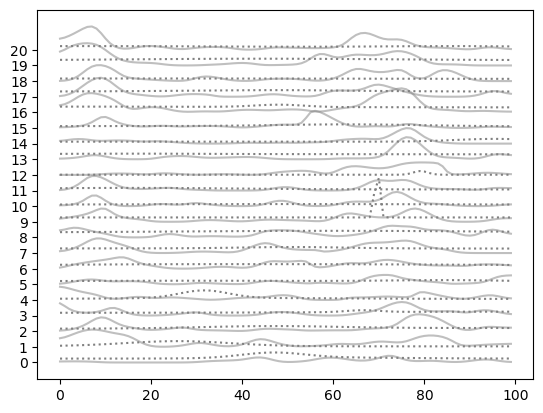

In [96]:
pars_ = pars_initial#pars#
tr=0
ys_l = fr_map_[tr][unit_ind_in_pyr]
pars_ = {k:val[trial_ind_dict[tr].astype(int)] for k,val in pars_.items()}
gp.plot_fit_original(ys_l,pars_,bin_to_lin=None,fig=None,ax=None,nooriginal=False,displacement=None)

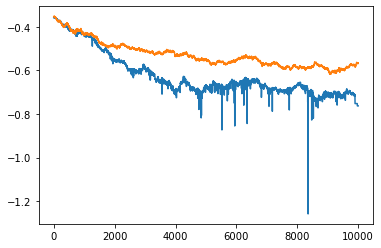

In [43]:
logprob_samples_rand_samples
plt.plot(logprob_samples_rand)


In [115]:
pars_samples['logsigmas'].shape

(10000, 35, 2)

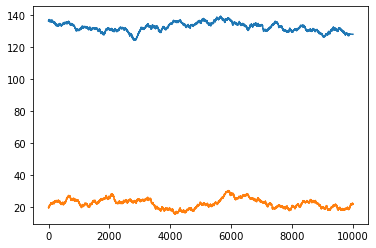

In [40]:
plt.plot(gm.softplus(pars_samples['logws'][:,3,1]))
plt.plot(gm.softplus(pars_samples_rand['logws'][:,3,1]))

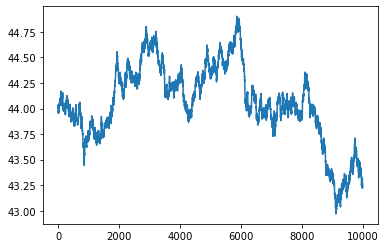

In [85]:
plt.plot(pars_samples['mus'][:,0,0])

In [118]:
states.logprob_grad

{'b': DeviceArray([[0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              ...,
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'logb': DeviceArray([[ 4.1311391e-04,  2.2536161e-04, -7.1146147e-05, ...,
               -2.0990359e-04, -8.3609502e-04, -1.8380601e-04],
              [ 4.4516270e-04,  2.4650461e-04, -6.7157220e-05, ...,
               -2.1400675e-04, -8.4460183e-04, -1.7535721e-04],
              [ 3.2967358e-04,  2.3492007e-04, -8.9121750e-05, ...,
               -1.8643978e-04, -8.4619055e-04, -1.8327300e-04],
              ...,
              [ 2.0067816e-04,  2.7215218e-03, -2.7189619e-04, ...,
                2.5760888e-03, -8.8975258e-04, -3.0776637e-04],
              [ 2.0067816e-04,  2.7215218e-03, -2.7189619e-04, ...,
                2.5760888e-03, -8.8975258e-04, -3.0776637e-04],
  

In [123]:
states.position['mus'][0].shape

(35, 2)

In [112]:
states.logprob

DeviceArray([-0.35755077, -0.35753226, -0.35749578, ..., -0.36077136,
             -0.36080635, -0.36080894], dtype=float32)

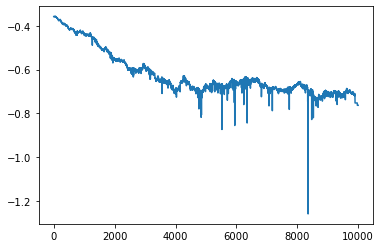

In [117]:
plt.plot(logprob_samples)

In [176]:
pars_samples['mus'][:10,0]

DeviceArray([[43.99996 , 72.00667 ],
             [43.99226 , 72.00778 ],
             [43.998547, 72.00684 ],
             [44.002842, 72.00972 ],
             [44.009003, 72.009346],
             [44.015995, 72.0111  ],
             [44.024624, 72.01443 ],
             [44.0247  , 72.01259 ],
             [44.03064 , 72.01812 ],
             [44.02758 , 72.02056 ]], dtype=float32)

In [179]:
pars_samples['mus'][:,0].shape

(1000, 2)

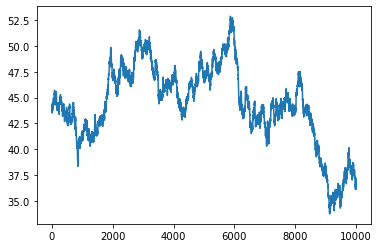

In [186]:
plt.plot(pars_samples['mus'][:,0,0])

In [122]:
fs_l_final = glm.forward(regressors,pars)

In [123]:
fs_l_final[1:1000]

DeviceArray([0.05652396, 0.05652611, 0.05654044, 0.05661952, 0.05695205,
             0.05789596, 0.06058337, 0.06652617, 0.0752892 , 0.08695078,
             0.10285887, 0.12125521, 0.14219289, 0.16228274, 0.18120177,
             0.19688351, 0.20801629, 0.21143696, 0.20891619, 0.20074068,
             0.18915595, 0.17465922, 0.15843308, 0.14166827, 0.12542558,
             0.11053611, 0.09637342, 0.08486737, 0.07673663, 0.07017694,
             0.06582776, 0.06326176, 0.0626903 , 0.06394418, 0.06657939,
             0.07137051, 0.07696976, 0.08425293, 0.09223064, 0.10164075,
             0.11241346, 0.12437569, 0.13559453, 0.14556119, 0.15395993,
             0.16395104, 0.1736103 , 0.18267633, 0.1921547 , 0.20200318,
             0.20857279, 0.21137142, 0.21051349, 0.18542427, 0.18275146,
             0.18138298, 0.1785868 , 0.17716117, 0.17425992, 0.17278628,
             0.16979805, 0.16828552, 0.16676201, 0.16676201, 0.16828552,
             0.16979805, 0.16979805, 0.16676201, 0.

In [64]:
fs_l_final[532]

DeviceArray(0., dtype=float32)

In [33]:
logpdf_no_reg(regressors,pars,target)

DeviceArray(-inf, dtype=float32)

In [24]:
target = fr[unit_str].values
lp=logpdf_poisson_no_reduce(regressors,pars,target)

In [25]:
lp

DeviceArray([-5.0120809e-07, -7.7244135e-07, -2.9189207e-06, ...,
             -1.8619337e+00, -2.1507567e-01, -2.4487755e-01],            dtype=float32)

In [17]:
stats.poisson.logpmf(,1)

DeviceArray(-5.7874928, dtype=float32)

In [80]:
regressors['position']

DeviceArray([  3.1310937,   3.1310937, 218.72816  , ..., 218.1976   ,
             218.28603  , 218.37445  ], dtype=float32)

In [79]:
fs_l_final[-1]

DeviceArray(nan, dtype=float32)

In [33]:
ws_l.shape

(55038, 2)

In [32]:
fs_all_trial_one_field_l_stacked.shape

(2, 55038)

In [49]:
gm.softplus(logsigmas_l[0,k])

DeviceArray(1., dtype=float32)

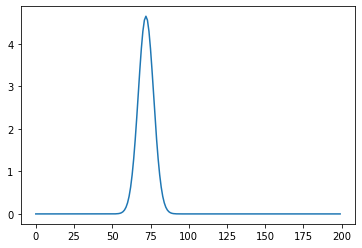

In [110]:
plt.plot(stats.norm.pdf(np.arange(200),loc=mus_l[0,k],scale=gm.softplus(logsigmas_l[0,k])) * gm.softplus(logws_l[0,k]))

In [126]:
trial_inds_int.iloc[0:5000]

203     0
204     0
205     0
206     0
207     0
       ..
5198    4
5199    4
5200    4
5201    4
5202    4
Name: trial, Length: 5000, dtype: int64

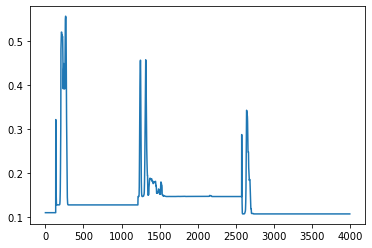

In [127]:

plt.plot(fs_l_final[4000:8000])

In [19]:
trial_ind_l=fr['trial'].astype(int)

In [21]:
position_l = fr['lin']

In [ ]:
def forward(regressors,pars):
    regressors
    return 
    

In [ ]:
gm.init_all_trials

In [5]:
ntrials = fr['trial'].nunique()

In [ ]:
nfields = 2

In [ ]:
keys = ['ws_l','mus_l','sigmas_l','b_l']
pars_init = {}
pars_init['ws_l'] = 
for k in keys:
    pars_init[k] = np.

35

In [ ]:
mus_l = 

In [ ]:
def 